In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# configurations
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 15
colors = ["#003560", "#EF4700", "#EFB400", "#00B917", "#72009F"]

In [3]:
# helper functions
def format_plot(xtick_labels, label_x, label_y):
    plt.xticks(np.arange(len(xtick_labels)), xtick_labels, rotation=45, ha="right")
    plt.xlabel(label_x)
    plt.ylabel(label_y)

def save_plot(filename):
    plt.tight_layout()
    plt.savefig("../paper/fig/" + filename)

In [4]:
# load data
step1 = pd.read_csv("../survey_tool/data/results/full_study/step1.csv")
test_persons = pd.read_csv("../survey_tool/data/results/full_study/test_persons.csv")

# General statistics

In [5]:
# Number of classified domains
len(step1)

14178

In [6]:
# How many domains were classified per participant?
step1["test_domain"].groupby(step1.user_id).count().describe()

count    288.000000
mean      49.229167
std       21.525358
min        1.000000
25%       37.000000
50%       48.000000
75%       59.250000
max      156.000000
Name: test_domain, dtype: float64

In [7]:
# How much time spent participants per domain?
step1["elapsed_time"].describe()

count    14178.000000
mean      2344.796798
std       2148.585397
min        272.000000
25%       1384.000000
50%       1873.500000
75%       2633.000000
max      93154.000000
Name: elapsed_time, dtype: float64

In [8]:
# Add columns:
# - correct_classification to determine whether the domain was classified correctly
# - mal_as_ben to determine whether a malicious domain was classified as benign
# - ben_as_mal to determine whether a benign domain was classified as malicious
step1 = step1.assign(correct_classification=False)
step1.loc[step1["classification"] == step1["result"], "correct_classification"] = True
step1 = step1.assign(mal_as_ben=False)
step1.loc[(step1["classification"] == 1) &
          (step1["classification"] != step1["result"]), "mal_as_ben"] = True
step1 = step1.assign(ben_as_mal=False)
step1.loc[(step1["classification"] == 0) &
          (step1["classification"] != step1["result"]), "ben_as_mal"] = True

In [9]:
# How many domains were classified correctly?
print(step1["correct_classification"].value_counts())

True     10767
False     3411
Name: correct_classification, dtype: int64


In [10]:
# How many domains were classified correctly (in %)?
print(step1["correct_classification"].value_counts() / len(step1))

True     0.759416
False    0.240584
Name: correct_classification, dtype: float64


In [11]:
# Precision
len(step1[(step1["classification"] == 1) & (step1["result"] == 1)]) / len(step1[step1["result"] == 1])

0.8774943976096468

In [12]:
# How many malicious domains were classified as benign?
step1[step1["mal_as_ben"] == True]["user_id"].count()

2263

In [13]:
# How many malicious domains were classified as benign (in % from all wrongly classified domains)?
step1[step1["mal_as_ben"] == True]["user_id"].count() /\
len(step1[step1["correct_classification"] == False])

0.663441805922017

In [14]:
# How many benign domains were classified as malicious?
step1[step1["ben_as_mal"] == True]["user_id"].count()

1148

In [15]:
# How many benign domains were classified as malicious (in % from all wrongly classified domains)?
step1[step1["ben_as_mal"] == True]["user_id"].count() /\
len(step1[step1["correct_classification"] == False])

0.336558194077983

In [16]:
# Which malicious domain was classified as benign and how often?
# TODO calculate ratio between wrong classifications and overall classifications
step1[step1["mal_as_ben"] == True]["test_domain"].value_counts()

docusignfolder.com                                 32
docusignfile.com                                   27
americanexpressbeta.com                            26
www.docusigner.org                                 26
www.login-linkedin.com                             25
                                                   ..
id.orange.fr.authuser2.bin.waltermarquez.com.ve     3
www.access.logon.online.yahoo.ververoom.com         3
idauthweb.orange.fr.bodrumsatilikemlak.net          2
suport-secur.com-paypall.ga                         1
drive.google.com.yaho.ml                            1
Name: test_domain, Length: 225, dtype: int64

In [17]:
# Which benign domain was classified as malicious and how often?
# TODO calculate ratio between wrong classifications and overall classifications
step1[step1["ben_as_mal"] == True]["test_domain"].value_counts()

ebpp3.wellsfargo.com    39
sso.dhl-usa.com         37
paypal.me               34
paypal-community.com    34
instagramers.com        32
                        ..
yahoo.com                2
paypal.com               2
instagram.com            2
dropbox.com              1
google.com               1
Name: test_domain, Length: 78, dtype: int64

# Statistics per User

In [18]:
# Create dataframe with statistics per user
statistics_per_user = {}
for index, row in step1.iterrows():
    user_id = row["user_id"]
    if user_id not in statistics_per_user:
        test_person = test_persons[test_persons.user_id==user_id]
        statistics_per_user[user_id] = {"domain_count": 0, "correct_classifications": 0,\
                                        "ben_classifications": 0, "mal_classifications": 0,\
                                        "ben_as_mal": 0, "mal_as_ben": 0, "mal_as_mal": 0,\
                                        "correct_ratio": 0.0,\
                                        "precision": 0.0,\
                                        "ben_ratio": 0.0, "mal_ratio": 0.0,\
                                        "mal_as_ben_ratio": 0.0, "ben_as_mal_ratio": 0.0,\
                                        "gender": test_person.gender.values[0],\
                                        "origin": test_person.origin.values[0],\
                                        "age": test_person.age.values[0],\
                                        "phishing": test_person.phishing.values[0]}
    statistics_per_user[user_id]["domain_count"] += 1
    if row["classification"] == 1 and row["result"] == 1:
        statistics_per_user[user_id]["mal_as_mal"] += 1
    if row["correct_classification"] == True:
        statistics_per_user[user_id]["correct_classifications"] += 1
    elif row["mal_as_ben"] == True:
        statistics_per_user[user_id]["mal_as_ben"] += 1
    elif row["ben_as_mal"] == True:
        statistics_per_user[user_id]["ben_as_mal"] += 1
    if row["result"] == 0:
        statistics_per_user[user_id]["ben_classifications"] += 1
    elif row["result"] == 1:
        statistics_per_user[user_id]["mal_classifications"] += 1

for user_id in statistics_per_user.keys():
    statistics_per_user[user_id]["correct_ratio"] = statistics_per_user[user_id]["correct_classifications"] /\
                                                    statistics_per_user[user_id]["domain_count"]
    statistics_per_user[user_id]["ben_ratio"] = statistics_per_user[user_id]["ben_classifications"] /\
                                                statistics_per_user[user_id]["domain_count"]
    statistics_per_user[user_id]["mal_ratio"] = statistics_per_user[user_id]["mal_classifications"] /\
                                                statistics_per_user[user_id]["domain_count"]
    wrong_classifications = statistics_per_user[user_id]["mal_as_ben"] + statistics_per_user[user_id]["ben_as_mal"]
    if wrong_classifications > 0:
        statistics_per_user[user_id]["mal_as_ben_ratio"] = statistics_per_user[user_id]["mal_as_ben"] / wrong_classifications
        statistics_per_user[user_id]["ben_as_mal_ratio"] = statistics_per_user[user_id]["ben_as_mal"] / wrong_classifications
    if statistics_per_user[user_id]["mal_classifications"]:    
        statistics_per_user[user_id]["precision"] = statistics_per_user[user_id]["mal_as_mal"] /\
                                                    statistics_per_user[user_id]["mal_classifications"]        
statistics_per_user = pd.DataFrame.from_dict(statistics_per_user, orient="index")

## All users

AxesSubplot(0.125,0.125;0.775x0.755)


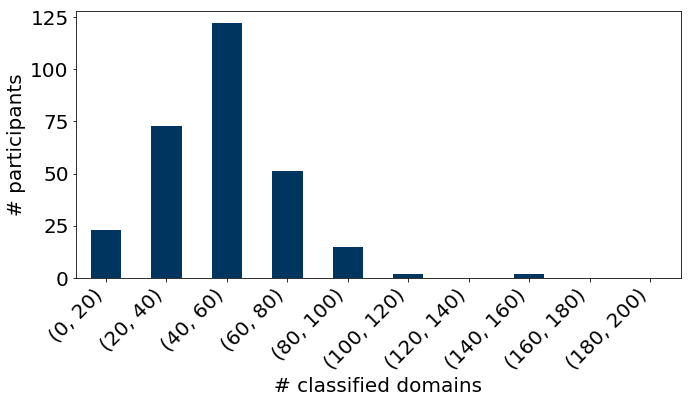

In [19]:
# How many domains were classified per participant
domain_count_bins = pd.cut(statistics_per_user.domain_count, bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], include_lowest=True)
print(domain_count_bins.value_counts().sort_index().plot(kind="bar", color=colors[0], legend=False))
labels = ("(0, 20)", "(20, 40)", "(40, 60)", "(60, 80)", "(80, 100)", "(100, 120)", "(120, 140)", "(140, 160)",\
          "(160, 180)", "(180, 200)")
format_plot(labels, "# classified domains", "# participants")
save_plot("step1_number_of_domains.pdf")

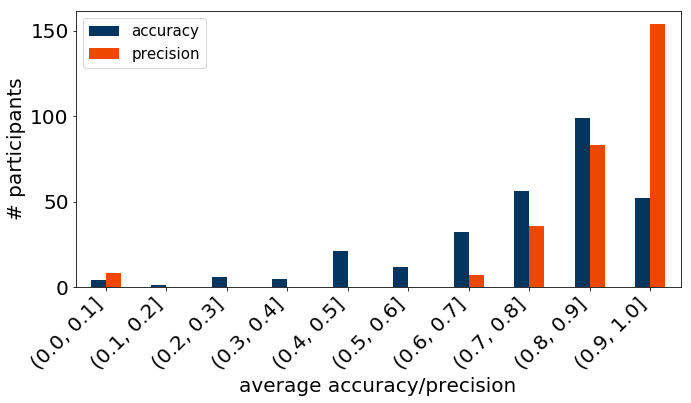

In [28]:
# How well were the domains classified per participant
accuracy_bins = pd.cut(statistics_per_user.correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
precision_bins = pd.cut(statistics_per_user.precision, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"accuracy": accuracy_bins.value_counts().sort_index(),\
              "precision": precision_bins.value_counts().sort_index()}).plot(kind="bar", color=colors)
labels = ("(0.0, 0.1]", "(0.1, 0.2]", "(0.2, 0.3]", "(0.3, 0.4]", "(0.4, 0.5]", "(0.5, 0.6]", "(0.6, 0.7]",\
          "(0.7, 0.8]", "(0.8, 0.9]", "(0.9, 1.0]")
format_plot(labels, "average accuracy/precision", "# participants")
save_plot("step1_classifications_per_user.pdf")

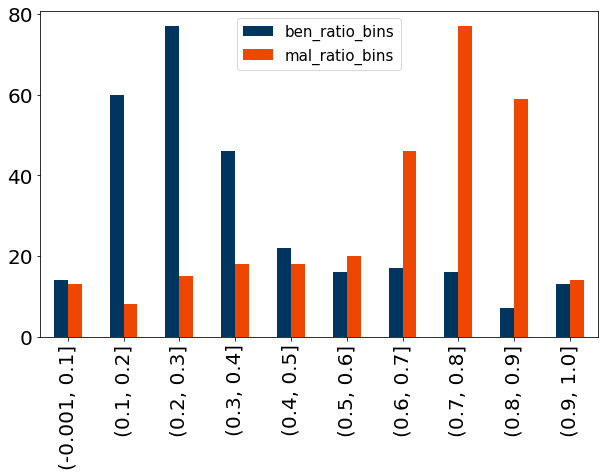

In [21]:
# How is the distribution of benign and malicious classifications among participants, i.e., are there participants who
# classify all domains as benign or malicious?
ben_ratio_bins = pd.cut(statistics_per_user.ben_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
mal_ratio_bins = pd.cut(statistics_per_user.mal_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"ben_ratio_bins": ben_ratio_bins.value_counts().sort_index(),\
              "mal_ratio_bins": mal_ratio_bins.value_counts().sort_index()}).plot(kind="bar", color=colors)

In [22]:
#pd.DataFrame({"ben_ratio_bins": ben_ratio_bins.value_counts().sort_index(),\
#              "mal_ratio_bins": mal_ratio_bins.value_counts().sort_index()})
ben_ratio_bins.value_counts()

(0.2, 0.3]       77
(0.1, 0.2]       60
(0.3, 0.4]       46
(0.4, 0.5]       22
(0.6, 0.7]       17
(0.7, 0.8]       16
(0.5, 0.6]       16
(-0.001, 0.1]    14
(0.9, 1.0]       13
(0.8, 0.9]        7
Name: ben_ratio, dtype: int64

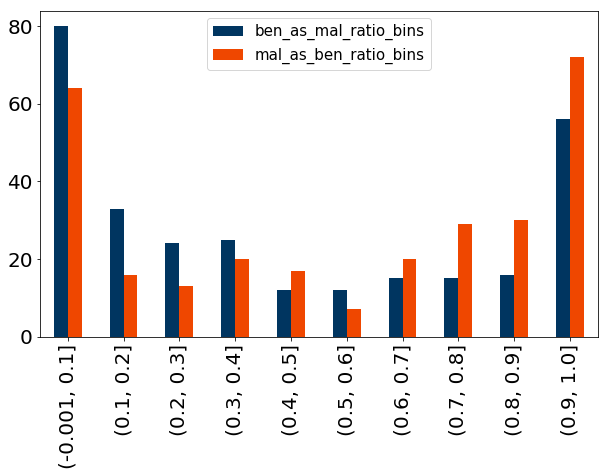

In [23]:
# How is the distribution of the benign as malicious ratio?
ben_as_mal_ratio_bins = pd.cut(statistics_per_user.ben_as_mal_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
mal_as_ben_ratio_bins = pd.cut(statistics_per_user.mal_as_ben_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"ben_as_mal_ratio_bins": ben_as_mal_ratio_bins.value_counts().sort_index(),\
              "mal_as_ben_ratio_bins": mal_as_ben_ratio_bins.value_counts().sort_index()}).plot(kind="bar", color=colors)

## Based on Phishing Experience

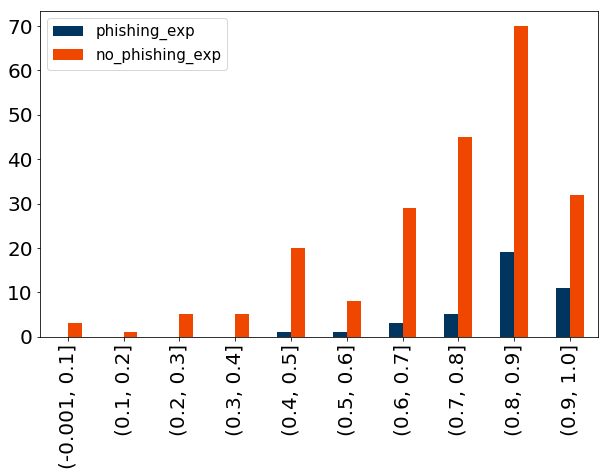

In [24]:
yes_bins = pd.cut(statistics_per_user[statistics_per_user.phishing=="yes"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
no_bins = pd.cut(statistics_per_user[statistics_per_user.phishing=="no"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"phishing_exp": yes_bins.value_counts().sort_index(),\
              "no_phishing_exp": no_bins.value_counts().sort_index()}).plot(kind="bar", color=colors)

## Based on Gender

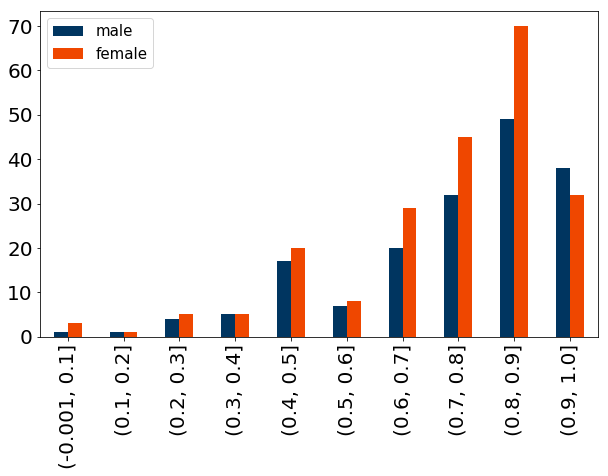

In [25]:
male_bins = pd.cut(statistics_per_user[statistics_per_user.gender=="male"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
female_bins = pd.cut(statistics_per_user[statistics_per_user.gender=="female"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"male": male_bins.value_counts().sort_index(),\
              "female": no_bins.value_counts().sort_index()}).plot(kind="bar", color=colors)

## Based on origin

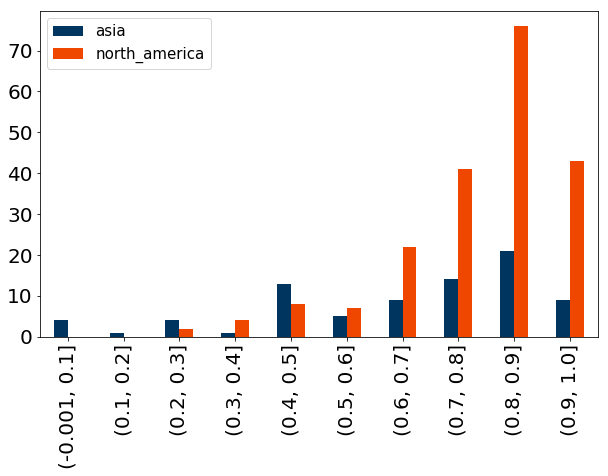

In [26]:
asia_bins = pd.cut(statistics_per_user[statistics_per_user.origin=="asia"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
north_america_bins = pd.cut(statistics_per_user[statistics_per_user.origin=="north_america"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"asia": asia_bins.value_counts().sort_index(),\
              "north_america": north_america_bins.value_counts().sort_index()}).plot(kind="bar", color=colors)

## Based on Age group

,domain_count,correct_classifications,ben_classifications,mal_classifications,ben_as_mal,mal_as_ben,mal_as_mal,correct_ratio,precision,ben_ratio,mal_ratio,mal_as_ben_ratio,ben_as_mal_ratio,gender,origin,age,phishing
ef03e9ec-33a3-4733-b714-fee31a93756b,51,43,12,39,6,2,33,0.843137,0.846154,0.235294,0.764706,0.250000,0.750000,male,north_america,36_45,no
be07c01a-ddd0-40ae-a147-e0e40fb895ab,68,57,17,51,1,10,50,0.838235,0.980392,0.250000,0.750000,0.909091,0.090909,female,north_america,26_35,yes
bf3eebee-327b-4136-b3fb-0729a71e93aa,52,44,9,43,5,3,38,0.846154,0.883721,0.173077,0.826923,0.375000,0.625000,female,north_america,26_35,yes
0537de69-16f9-4fc6-be8f-f34537a7f01f,61,33,35,26,3,25,23,0.540984,0.884615,0.573770,0.426230,0.892857,0.107143,male,asia,26_35,no
3e906259-bd1f-4ed5-b5ad-c11a81e9d5c3,47,44,11,36,3,0,33,0.936170,0.916667,0.234043,0.765957,0.000000,1.000000,male,north_america,26_35,no
bda40549-d39d-4a43-88a9-a06ba251d1d7,60,53,13,47,6,1,41,0.883333,0.872340,0.216667,0.783333,0.142857,0.857143,female,north_america,36_45,no
ff1048ec-3f11-44c1-a715-dc632b86aee7,55,44,27,28,3,8,25,0.800000,0.892857,0.490909,0.509091,0.727273,0.272727,female,north_america,36_45,no
78b800ab-37b4-43d5-9b88-f984c92d06a3,51,36,20,31,4,11,27,0.705882,0.870968,0.392157,0.607843,0.733333,0.266667,male,north_america,26_35,not_known
30f8b39d-0439-4571-89b7-da317d433397,42,16,36,6,0,26,6,0.380952,1.000000,0.857143,0.142857,1.000000,0.000000,male,north_america,26_35,no
75a4ca19-07a5-4161-8ac4-ade4579049b2,48,37,15,33,4,7,29,0.770833,0.878788,0.312500,0.687500,0.636364,0.363636,non_binary,north_america,over_55,no


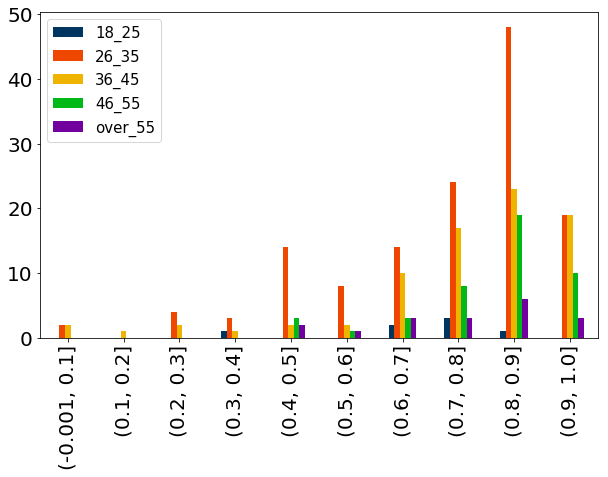

In [39]:
bins_18_25 = pd.cut(statistics_per_user[statistics_per_user.age=="18_25"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
bins_26_35 = pd.cut(statistics_per_user[statistics_per_user.age=="26_35"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
bins_36_45 = pd.cut(statistics_per_user[statistics_per_user.age=="36_45"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
bins_46_55 = pd.cut(statistics_per_user[statistics_per_user.age=="46_55"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
bins_over_55 = pd.cut(statistics_per_user[statistics_per_user.age=="over_55"].correct_ratio, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], include_lowest=True)
pd.DataFrame({"18_25": bins_18_25.value_counts().sort_index(),\
              "26_35": bins_26_35.value_counts().sort_index(),\
              "36_45": bins_36_45.value_counts().sort_index(),\
              "46_55": bins_46_55.value_counts().sort_index(),\
              "over_55": bins_over_55.value_counts().sort_index()}).plot(kind="bar", color=colors)


In [35]:
import scipy as sp
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

dataFrame = pd.DataFrame(data=statistics_per_user);

#print("DataFrame:");
#print(dataFrame);

correlation    = dataFrame.corr(method="pearson");

print("Pearson correlation coefficient:");
print(correlation);

calculate_pvalues(dataFrame)

 

Pearson correlation coefficient:
                         domain_count  correct_classifications  \
domain_count                 1.000000                 0.849542   
correct_classifications      0.849542                 1.000000   
ben_classifications          0.387115                -0.077349   
mal_classifications          0.777716                 0.937652   
ben_as_mal                   0.646541                 0.618602   
mal_as_ben                   0.258944                -0.258363   
mal_as_mal                   0.761706                 0.965900   
correct_ratio                0.102213                 0.525185   
precision                    0.130347                 0.202702   
ben_ratio                   -0.273573                -0.628461   
mal_ratio                    0.273573                 0.628461   
mal_as_ben_ratio            -0.286596                -0.544803   
ben_as_mal_ratio             0.336409                 0.569359   

                         ben_classificatio

,domain_count,correct_classifications,ben_classifications,mal_classifications,ben_as_mal,mal_as_ben,mal_as_mal,correct_ratio,precision,ben_ratio,mal_ratio,mal_as_ben_ratio,ben_as_mal_ratio
domain_count,0,0,0,0,0,0,0,0.0833,0.027,0,0,0,0
correct_classifications,0,0,0.1906,0,0,0,0,0,0.0005,0,0,0,0
ben_classifications,0,0.1906,0,0,0.0005,0,0,0,0.0734,0,0,0,0
mal_classifications,0,0,0,0,0,0,0,0,0.2809,0,0,0,0
ben_as_mal,0,0,0.0005,0,0,0.0006,0,0.0633,0.0001,0,0,0,0
mal_as_ben,0,0,0,0,0.0006,0,0,0,0.6998,0,0,0,0
mal_as_mal,0,0,0,0,0,0,0,0,0.014,0,0,0,0
correct_ratio,0.0833,0,0,0,0.0633,0,0,0,0,0,0,0,0
precision,0.027,0.0005,0.0734,0.2809,0.0001,0.6998,0.014,0,0,0,0,0.0157,0.1937
ben_ratio,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

chisq_of_df_cols(dataFrame, 'correct_ratio', 'gender')

(479.5785440613027,
 0.9999987028280003,
 633,
 array([[1.12500000e+00, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 7.50000000e-01, 3.75000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 7.50000000e-01, 3.75000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 7.50000000e-01,
         3.75000000e-01, 3.75000000e-01, 3.75000000e-01, 7.50000000e-01,
         3.75000000e-01, 7.50000000e-01, 3.75000000e-01, 3.75000000e-01,
    